In [1]:
import xarray as xr
import numpy as np
from scipy.io import loadmat
import matplotlib as mpl
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import cartopy.crs as ccrs

In [2]:
# Data load and pre-processing
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Oct_13_2022_precompute\\"
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing')
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])
file_index = 0 #Process single file from list below
ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
antenna_ident = ss.utils.tools.antenna_idents(ds)
ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)

OSCAR L1 processing
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022_precompute\
-------------------
File index : 0 , Aquisition time : 20220517T093239 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220525T080646 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220525T085452 , File list indices : [6, 7, 8]


In [3]:
# L1 processing
for i in list(ds.keys()):
    ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
    ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window=7)
    ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
    ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
    ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
    ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
#Build L1 dataset
dsl1 = ss.oscar.level1.merge_beams(ds, antenna_ident)
# Generating geophysical data fields for GMF doppler computation
u10 = 7 # wind speed
wind_direction = 190 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,u10,wind_direction)
# Compute RSC
dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1.sel(Antenna=['Fore','Aft']), aux, gmf='mouche12')

#L2 Processing
# Initialise l2 dataset
dsl2=ss.oscar.level1.init_level2(dsl1)
# Compute current magnitude and direction
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)


In [4]:
# Load and colocate auxiliary data
xband_file="D:\data\SEASTAR\SEASTARex\Data\Hereon\Xband_radar_17th_may.mat"
ds_xband = ss.retrieval.auxiliary.colocate_xband_marine_radar_data(xband_file, dsl2)
ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'] =ss.retrieval.auxiliary.\
compute_Xband_current_magnitude_and_direction(ds_xband)

In [5]:
# Compute current vectors

dsl2['CurrentVectorUComponent'], dsl2['CurrentVectorVComponent'] =\
ss.utils.tools.currentVelDir2UV(dsl2['CurrentMagnitude'], dsl2['CurrentDirection'])

ds_xband['CurrentVectorUComponent'], ds_xband['CurrentVectorVComponent'] =\
ss.utils.tools.currentVelDir2UV(ds_xband['CurrentMagnitude'], ds_xband['CurrentDirection'])

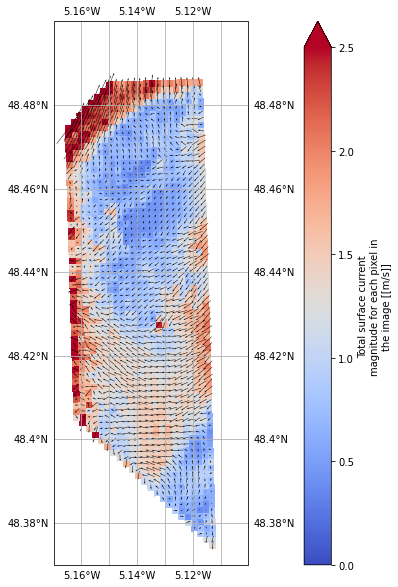

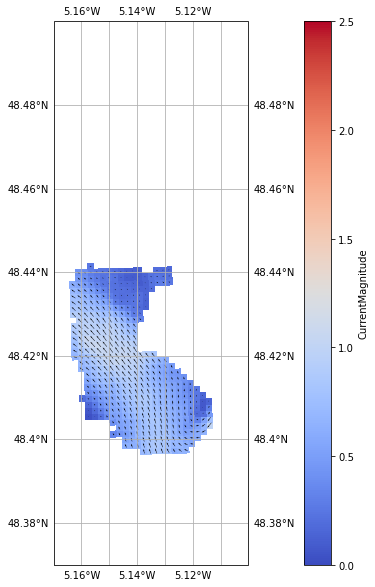

In [6]:
# Plot current magnitude with u,v vectors overlain, geographic coordinates

c_factor = 20 # Coarsening factor
q_factor = 30 # Quiver plot scaling factor


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
dsl2\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=2.5,
    transform=ccrs.PlateCarree()
)
dsl2\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentVectorUComponent',
    v='CurrentVectorVComponent',
    scale=q_factor,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())


fig2 = plt.figure(figsize=(20, 10))
ax2 = fig2.add_subplot(1,1,1, projection=ccrs.Mercator())
ds_xband\
.coarsen(GroundRange=c_factor,boundary='trim').mean()\
.coarsen(CrossRange=c_factor,boundary='trim').mean()\
.CurrentMagnitude.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='coolwarm',
    vmin=0, vmax=2.5,
    transform=ccrs.PlateCarree()
)

ds_xband\
.coarsen(GroundRange=20,boundary='trim').mean()\
.coarsen(CrossRange=20,boundary='trim').mean()\
.plot.quiver(
    x='longitude',
    y='latitude',
    u='CurrentVectorUComponent',
    v='CurrentVectorVComponent',
    scale=q_factor,
    angles='xy',
    robust=True,
    transform=ccrs.PlateCarree()
)
gl=ax2.gridlines(draw_labels=True)
ax2.set_extent([-5.17, -5.1, 48.37, 48.5], crs=ccrs.PlateCarree())